# Machine Learning for Geoscience

<div class="questions">  
### Questions

- What data science tools and techniques can be used in Python?
- How do I do it?
</div>

<div class="objectives">  
### Objectives

- Learn fundamental Machine Learning packages.
- Learn to further explore data.
</div>

Let's use some standard Machine Learning tools available in Python packages to analyse some data.

We have a dataset (from Butterworth et al. 2016) with a collection of tectonomagmatic parameters associated with the time and location of porphyry copper deposits. We want to determine which of these (if any) parameters are geologically important (or at least statistically significant) in relation to the formation of porphyry coppers.

Below is an animation of the tectonomagmatic evolution of the South American plate margin since 150Ma, representing many of the parameters in the data.

![SegmentLocal](fig/MullerConvergenceSmall.gif "segment")

## Import most of the modules we need
By convention module loads go at the top of your workflows.


In [1]:
import pandas #For dealing with data structures
import numpy as np #Data array manipulation
import scipy #Scientific Python, has lots of useful tools
import scipy.io #A specific sub-module for input/output of sci data

#scikit-learn tools to perform machine learning classification
#from sklearn import cross_validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing

#For making pretty figures
import matplotlib.pyplot as plt 
from matplotlib import cm

#For easy geographic projections on a map
import cartopy.crs as ccrs

#For dealing with shapefiles
import shapefile


## Load in the data

In [2]:
#Use pandas to load in the machine learning dataset
ml_data=pandas.read_csv("../data/ml_data_points.csv",index_col=0)

In [3]:
#Print out the dataset so we can see what it looks like
ml_data

,0 Present day longitude (degrees),1 Present day latitude (degrees),2 Reconstructed longitude (degrees),3 Reconstructed latitude (degrees),4 Age (Ma),5 Time before mineralisation (Myr),6 Seafloor age (Myr),7 Segment length (km),8 Slab length (km),9 Distance to trench edge (km),...,11 Subducting plate parallel velocity (km/Myr),12 Overriding plate normal velocity (km/Myr),13 Overriding plate parallel velocity (km/Myr),14 Convergence normal rate (km/Myr),15 Convergence parallel rate (km/Myr),16 Subduction polarity (degrees),17 Subduction obliquity (degrees),18 Distance along margin (km),19 Subduction obliquity signed (radians),20 Ore Deposits Binary Flag (1 or 0)
0,-66.28,-27.37,-65.264812,-28.103781,6.0,0.0,48.189707,56.08069,2436.30907,2436.30907,...,40.63020,-17.43987,12.20271,102.31471,28.82518,5.67505,15.73415,2269.19769,0.274613,1.0
1,-69.75,-30.50,-67.696759,-31.970639,12.0,0.0,52.321162,56.09672,2490.68735,2490.68735,...,39.60199,-22.80622,13.40127,115.35820,27.39401,5.78937,13.35854,1823.34107,0.233151,1.0
2,-66.65,-27.27,-65.128689,-28.374772,9.0,0.0,53.506085,55.77705,2823.54951,2823.54951,...,45.32425,-18.08485,11.27500,100.24282,34.62444,8.97218,19.05520,2269.19769,0.332576,1.0
3,-66.61,-27.33,-65.257928,-28.311094,8.0,0.0,51.317135,55.90088,2656.71724,2656.71724,...,43.13319,-17.78538,11.72618,101.21965,31.92962,7.42992,17.50782,2269.19769,0.305569,1.0
4,-66.55,-27.40,-65.366917,-28.257580,7.0,0.0,49.340097,56.09011,2547.29585,2547.29585,...,40.57322,-17.43622,12.23778,102.25748,28.80235,5.65657,15.73067,2269.19769,0.274552,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,-78.67,-6.73,-70.657487,-11.057387,39.0,0.0,62.727249,56.14919,5373.67650,1076.30110,...,13.21524,-25.08597,12.24246,60.45651,-7.46828,-22.30925,7.04216,4708.08568,-0.122909,0.0
297,-75.09,-13.69,-37.112536,-19.124363,121.0,0.0,30.740063,54.09642,269.79929,269.79929,...,-39.68330,11.56758,7.99788,-19.41449,-59.05957,-46.36908,71.80290,3761.82099,1.253197,0.0
298,-71.31,-14.91,-38.398992,-21.934657,151.0,0.0,17.739843,53.93117,323.86191,323.86191,...,-3.42257,-17.25992,-22.78837,8.88338,-7.68381,-40.99490,40.85864,3378.69739,-0.713118,0.0
299,-70.61,-17.25,-37.243172,-24.160112,145.0,0.0,11.744395,53.94534,163.59542,163.59542,...,-2.26253,14.87833,0.05195,2.36178,-23.78566,-38.97366,84.32944,3160.06366,-1.471826,0.0


There are 21 columns (python (usually) counts from 0) representing different parameters. Some of these parameters may be useful for us. Some are not. The final column contains a binary flag representing whether there is a known porphyry copper deposit at that location or not. The "non-deposits" are required to train our Machine Learning classifier what a porphyry deposit looks like, and also, what a porphyry deposit doesn't look like!

## Perform Machine Learning binary classification.

In [4]:
#Change data format to numpy array for easy manipulation
ml_data_np=ml_data.values

#Set the indices of the parameters (features) to include in the ML
#params=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
# Alternatively try include any set of features you'd like to include!
#params=[6,9,14,17] 
params=[16,17,18,19] 


#Save the number of parameters we have chosen
datalength=len(params)

#Normalise the data for Machine Learning
ml_data_norm=preprocessing.scale(ml_data_np[:,params])

#Create a 'feature vector' and a 'target classification vector'
features=ml_data_norm
targets=ml_data_np[:,20]

#Print out some info about our final dataset
print("Shape of ML data array: ", ml_data_norm.shape)
print("Positive (deposits) examples: ",np.shape(ml_data_np[ml_data_np[:,20]==1,:]))
print("Negative (non-deposits) examples: ",np.shape(ml_data_np[ml_data_np[:,20]==0,:]))

Shape of ML data array:  (301, 4)
Positive (deposits) examples:  (147, 21)
Negative (non-deposits) examples:  (154, 21)


In [5]:
print('Make the classifiers')

print('Random Forest...')
#create and train the random forest
#multi-core CPUs can use: rf = RandomForestClassifier(n_estimators=100, n_jobs=2)
#n_estimators use between 64-128 doi: 10.1007/978-3-642-31537-4_13
rf = RandomForestClassifier(n_estimators=128, n_jobs=1,class_weight=None)
rf.fit(features,targets)
print("Done RF")

scores = cross_val_score(rf, features,targets, cv=10)
print("RF Scores: ",scores)
print("SCORE Mean: %.2f" % np.mean(scores), "STD: %.2f" % np.std(scores), "\n")

print("Targets (expected result):")
print(targets)

print("Prediction (actual result):")
print(rf.predict(features))

Make the classifiers
Random Forest...
Done RF
RF Scores:  [0.74193548 0.8        0.6        0.66666667 0.8        0.63333333
 0.4        0.63333333 0.66666667 0.7       ]
SCORE Mean: 0.66 STD: 0.11 

Targets (expected result):
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

Importance 	 Feature
0.288 		 16 Subduction polarity (degrees)
0.285 		 17 Subduction obliquity (degrees)
0.157 		 18 Distance along margin (km)
0.270 		 19 Subduction obliquity signed (radians)


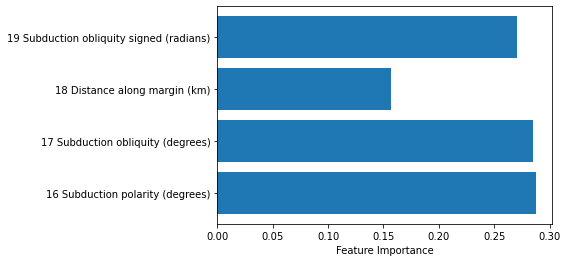

In [6]:
#Make a list of labels for our chosen features
paramColumns=np.array(ml_data.columns)
paramLabels=paramColumns[params].tolist()

#Create a new figure
fig, ax = plt.subplots()

#Plot the bar graph
rects=ax.barh(np.arange(0, datalength, step=1),rf.feature_importances_)

#Label the axes
ax.set_yticks(np.arange(0, datalength, step=1))
ax.set_yticklabels(paramLabels)
ax.set_xlabel('Feature Importance')

#Print the feature importance to compare with plot
np.set_printoptions(precision=3,suppress=True)
print("Importance \t Feature")
for i,label in enumerate(paramLabels):
    print("%1.3f \t\t %s" % (rf.feature_importances_[i],label))

plt.show()


Now if we can measure the tectonomagmatic properties at some point. Based on our trained classifier we can predict a probability that porphyry copper deposits have formed


In [7]:
#Apply the trained ML to our gridded data to determine the probabilities at each of the points
print('RF...')
pRF=np.array(rf.predict_proba(features))
print("Done RF")

RF...
Done RF


In [8]:
#Now you have a working ML model. You can use NEW DATA (you go and collect in the field or whatever)
#to make predictions
newdata = np.array([[0.5, -0.6, -0.7,  0.2]])
rf.predict_proba(newdata)

array([[0.812, 0.188]])

## Mapping the ML result

In [10]:
filename="../data/topodata.nc"
data = scipy.io.netcdf.netcdf_file(filename,'r')

data.variables

/tmp/ipykernel_2626860/2264377247.py:2: DeprecationWarning: Please use `netcdf_file` from the `scipy.io` namespace, the `scipy.io.netcdf` namespace is deprecated.
  data = scipy.io.netcdf.netcdf_file(filename,'r')


{'X': <scipy.io._netcdf.netcdf_variable at 0x7f9e236a0c10>,
 'Y': <scipy.io._netcdf.netcdf_variable at 0x7f9e236a0ac0>,
 'elev': <scipy.io._netcdf.netcdf_variable at 0x7f9e236a0d00>}

In [11]:
topoX=data.variables['X'][:]
topoY=data.variables['Y'][:]
topoZ=np.array(data.variables['elev'][:])

#Some file types and readers (like netcdf) can actually change the data directly on disk
#Good practice, is to close the file when done (for safety and memory saving)
data.close()

/home/nbutter/miniconda3/envs/PESA/lib/python3.9/site-packages/scipy/io/_netcdf.py:304: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  warnings.warn((


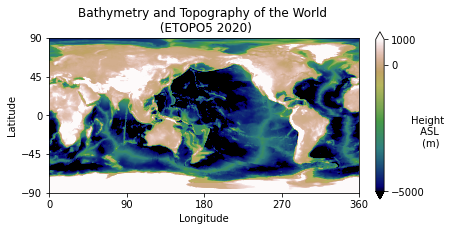

In [12]:
#Make a figure object
plt.figure()

#Get the axes of the current figure, for manipulation
ax = plt.gca()

#Put down the main topography dataset
im=ax.imshow(topoZ,vmin=-5000,vmax=1000,extent=[0,360,-90,90],origin='upper',aspect=1,cmap=cm.gist_earth)

#Make a colorbar
cbar=plt.colorbar(im,fraction=0.025,pad=0.05,ticks=[-5000,0, 1000],extend='both')
cbar.set_label('Height \n ASL \n (m)', rotation=0)

#Clean up the default axis ticks
plt.yticks([-90,-45,0,45,90])
plt.xticks([0,90,180,270,360])

#Put labels on the figure
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

#Put a title on it
plt.title("Bathymetry and Topography of the World \n (ETOPO5 2020)")

plt.show()

## Plotting shapefiles with for loops

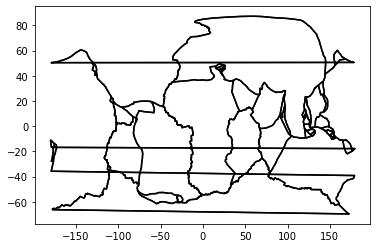

In [13]:
#Load in plate polygons for plotting
topologyFile='data/platepolygons/topology_platepolygons_0.00Ma.shp'

#read in the file
shapeRead = shapefile.Reader(topologyFile)

#And save out some of the shape file attributes
recs    = shapeRead.records()
shapes  = shapeRead.shapes()
fields  = shapeRead.fields
Nshp    = len(shapes)

for i, nshp in enumerate(range(Nshp)):
    #if nshp!=35 and nshp!=36 and nshp!=23:
    #These are the plates that cross the dateline and cause 
        #banding errors
        polygonShape=shapes[nshp].points
        poly=np.array(polygonShape)
        plt.plot(poly[:,0], poly[:,1], c='k',zorder=1)
        
plt.show()

## Cartopy for a prettier map


Made base map
Added topo
Added shapes
Added deposit probability


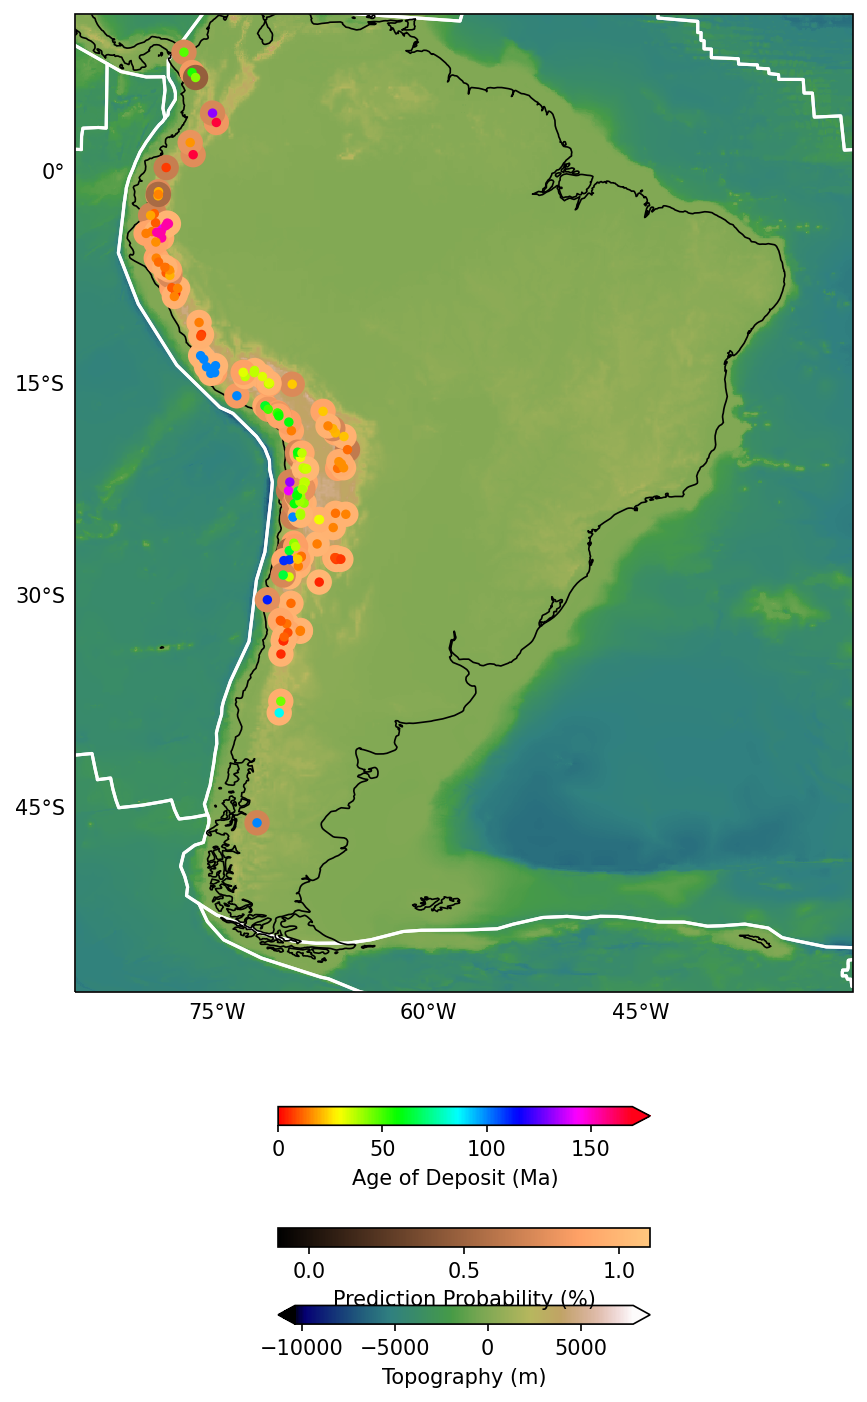

In [13]:
###Set up the figure
fig = plt.figure(figsize=(16,12),dpi=150)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-85, -30, -55, 10])
ax.coastlines('50m', linewidth=0.8)

###Add the map grid lines and format them
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='-')

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from matplotlib import colorbar, colors

gl.top_labels = False
gl.left_labels = True
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xlocator = mticker.FixedLocator([-75,-60, -45,-30])
gl.ylocator = mticker.FixedLocator([-60, -45, -30, -15, 0,15])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
#gl.xlabel_style = {'size': 15, 'color': 'gray'}
#gl.xlabel_style = {'color': 'black', 'weight': 'normal'}

print("Made base map")

###Plot a topography underlay image
#Make a lat lon grid to fit the topo grid
lons, lats = np.meshgrid(topoX,topoY)
im1=ax.pcolormesh(lons,lats,topoZ, shading="auto",cmap=plt.cm.gist_earth,transform=ccrs.PlateCarree())              
cbar=plt.colorbar(im1, ax=ax, orientation="horizontal", pad=0.01, fraction=0.05, shrink=0.2,extend='both')
cbar.set_label('Topography (m)')

print("Added topo")

###Plot shapefile polygon outlines
#Load in plate polygons for plotting
topologyFile='../data/platepolygons/topology_platepolygons_0.00Ma.shp'

#read in the file
shapeRead = shapefile.Reader(topologyFile)

#And save out some of the shape file attributes
recs    = shapeRead.records()
shapes  = shapeRead.shapes()
fields  = shapeRead.fields
Nshp    = len(shapes)

for i, nshp in enumerate(range(Nshp)):
    if nshp!=35 and nshp!=36 and nshp!=23:
    #These are the plates that cross the dateline and cause 
        #banding errors
        polygonShape=shapes[nshp].points
        poly=np.array(polygonShape)
        xh=poly[:,0]
        yh=poly[:,1]
        ax.plot(xh, yh, c='w',zorder=1)

print("Added shapes")
        
###Plot the ore deposit probability
xh = ml_data_np[ml_data_np[:,-1]==1,0]
yh= ml_data_np[ml_data_np[:,-1]==1,1]
l2 = ax.scatter(xh, yh, 500, marker='.',c=pRF[:147,1],cmap=plt.cm.copper,zorder=3,transform=ccrs.PlateCarree(),vmin=0,vmax=1)
#l2 = pmap.scatter(xh, yh, 20, marker='.',edgecolor='dimgrey',linewidth=0.5,c=pRF[:147,1],cmap=plt.cm.copper,zorder=3)
cbar=fig.colorbar(l2, ax=ax, orientation="horizontal", pad=0.05, fraction=0.05, shrink=0.2,ticks=[0,0.5,1.0])
l2.set_clim(-0.1, 1.1)
cbar.set_label('Prediction Probability (%)')

###Plot the ore deposit Age
xh=ml_data_np[ml_data_np[:,-1]==1,0]
yh = ml_data_np[ml_data_np[:,-1]==1,1]
l2 = ax.scatter(xh, yh, 50, marker='.',c=ml_data_np[ml_data_np[:,-1]==1,4],cmap=plt.cm.hsv,zorder=3)
cbar=fig.colorbar(l2, ax=ax, orientation="horizontal", pad=0.1, fraction=0.05, shrink=0.2,extend='max',ticks=[0,50,100,150])
l2.set_clim(0, 170)
cbar.set_label('Age of Deposit (Ma)')

print("Added deposit probability")

plt.show()

## Exercise
Do the same analysis but using a different Machine Learning algorithm for your classification. You can use this as a guide for picking a good classification algorithm [https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html). 
Present your results on a map, and compare it with the Random Forest method. 

## Datasets

#### Topography/Bathymetry
WORLDBATH: ETOPO5 5x5 minute Navy bathymetry. http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NGDC/.ETOPO5/
    
#### ML dataset
Butterworth et al 2016 https://doi.org/10.1002/2016TC004289

#### Shapefile plate polygons
GPlates2.0. https://www.gplates.org/

<div class="keypoints">
### Key points

- Applying ML workflows
- Wrangling data.
</div>

